# **PSET 2**

 These are some of the libraries/modules you will require for this homework.

In [130]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import cv2
import numpy as np
import scipy
from scipy import ndimage
from scipy.signal import convolve
from scipy.signal import convolve2d
from PIL import Image
import skimage
from skimage import data
from skimage.transform import warp, AffineTransform
import matplotlib.pyplot as plt
import copy
import os

These are some functions which will be useful throught the homework to (1) display a single grayscale image, (2) display multiple images using subplots.

In [89]:
def display_gray(x: np.array, normalized:bool = False):
    plt.figure(figsize=(10,10))
    if not normalized:
        plt.imshow(x,cmap='gray',vmin=0,vmax=1)
    else:
        plt.imshow(x/x.max(),cmap='gray',vmin=0,vmax=1)

In [90]:
def display_axis(ax: plt.axis, x: np.array, title: str, normalized:bool = False):
    if not normalized:
        ax.imshow(x,cmap='gray',vmin=0,vmax=1)
    else:
        ax.imshow(x/x.max(),cmap='gray',vmin=0,vmax=1)
    ax.set_title(title,size=18)

In [91]:
def display_axis_bw(ax: plt.axis, x: np.array, title: str, normalized:bool = False, fig = None):
    if not normalized:
        imax = ax.imshow(x,cmap='gray',vmin=0,vmax=1)
    else:
        imax = ax.imshow(x/x.max(),cmap='gray',vmin=0,vmax=1)
    ax.set_title(title,size=18)
    fig.colorbar(imax,ax=ax)

In [92]:
def display_axis_color(ax: plt.axis, x: np.array, title: str, normalized:bool = False, fig = None):
    if not normalized:
        imax = ax.imshow(x,cmap='coolwarm',vmin=0,vmax=1)
    else:
        imax = ax.imshow(x/x.max(),cmap='coolwarm',vmin=0,vmax=1)
    ax.set_title(title,size=18)
    fig.colorbar(imax,ax=ax)

# Question 2

### Blob Detection

In this question, you will be using the Laplacian of Gaussian Filter to perform blob detection. Using the previous parts of the question you should have an analytical expression for the Laplacian of Gaussian. You will be using that result to design a LoG filter. You will then be using that filter to detect blobs of different scales in the image by varying the standard deviation parameter.


In [93]:
def conv2D(image: np.array, kernel: np.array = None) -> np.array:
    if kernel is None:
        kernel = np.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]])

    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    pad_height = (kernel_height - 1) // 2
    pad_width = (kernel_width - 1) // 2

    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    output = np.zeros_like(image)

    for i in range(pad_height, image_height + pad_height):
        for j in range(pad_width, image_width + pad_width):
            output[i - pad_height, j - pad_width] = np.sum(kernel * 
            padded_image[i - pad_height:i + pad_height + 1, j - pad_width:j + pad_width + 1])

    return output

We use the two functions below to create blobs of different sizes. You will have 5 different sizes of blobs in the image below. You will have to tune the standard deviation of your LoG filter such that you get the maximum response.

In [94]:
def make_circle(img: np.array, x: int, y: int, radius: int):
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if np.sqrt((x-i)**2 + (y-j)**2) < 1.0*radius:
                img[i,j]=1
    return img

In [95]:
def draw_circle(img, y, radius):
    rad_buffer = radius + 5
    start = rad_buffer+5
    end = 255 - rad_buffer - 5
    centers = np.linspace(start, end, int((end-start)/(2*rad_buffer)))
    for c in centers:
        c = int(c)
        make_circle(img, y, c, radius)
    return img

In [96]:
blob_img = np.zeros((256,256))
blob_img = draw_circle(blob_img, 25, 5)
blob_img = draw_circle(blob_img, 50, 10)
blob_img = draw_circle(blob_img, 85, 15)
blob_img = draw_circle(blob_img, 130, 20)
blob_img = draw_circle(blob_img, 200, 35)

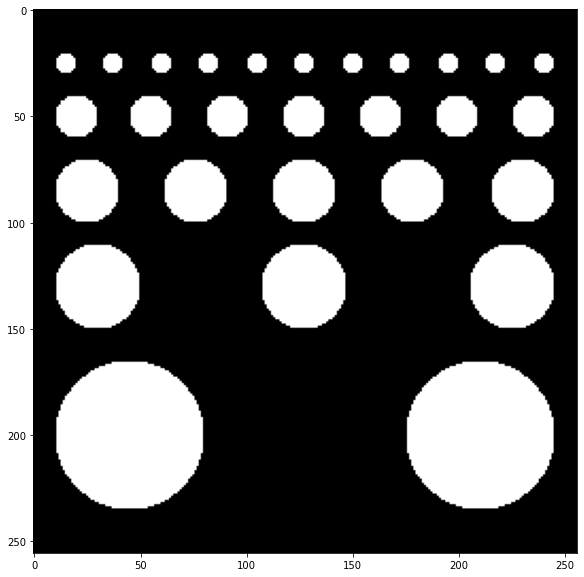

In [97]:
display_gray(blob_img)

In [98]:
img = copy.deepcopy(blob_img)

#### **Answer 2.5**

For this sub-part, you will be writing a function `log_filter(size, sigma)`, which takes as input the size of the LoG filter and the sigma, and returns a scale-normalized LoG filter.

Copy paste your solution in the cell below on Overleaf for Question 2.5.

In [105]:
def log_filter(size: int, sigma: float): 
    x, y = np.meshgrid(np.arange(-size//2+1, size//2+1), np.arange(-size//2+1, size//2+1))
    log_kernel = ((x**2 + y**2 - 2*sigma**2)/(sigma**4)) * np.exp(-(x**2 + y**2)/(2*sigma**2))
    log_kernel = log_kernel - np.mean(log_kernel)
    log_kernel = log_kernel / np.sqrt(np.sum(log_kernel**2))
    
    return log_kernel

As you might have seen above, the image blobs have 5 different scales. Hence you have to find 5 `sigma` values which will give maximum response when the LoG filter is convolved with the image. You may want to use the results from the class lectures to find the values for `sigma`. To visualize maximum response we will be plotting the filtered images using a color map where blue color would correspond to smaller values and red color would correspond to higher values.

#### **Answer 2.6**

Tune the values of the 5 `sigmas`, so that you get the maximum response for each scale. So, `sigma_1` should be such that you get the maximum response for the smallest blobs, `sigma_5` should give you the maximum response for the largest blobs.

Write the values of the 5 `sigmas` you get here on Overleaf.

In [106]:
sigma_1 = 5/np.sqrt(2)
log_1 = log_filter(21, sigma_1)
sigma_2 = 10/np.sqrt(2)
log_2 = log_filter(31, sigma_2)
sigma_3 = 15/np.sqrt(2)
log_3 = log_filter(41, sigma_3)
sigma_4 = 20/np.sqrt(2)
log_4 = log_filter(51, sigma_4)
sigma_5 = 25/np.sqrt(2)
log_5 = log_filter(81, sigma_5)

#### **Answer 2.7**

In this sub-part, you will visualize the LoG filters.

Upload the saved image on Overleaf for Question 2.7.

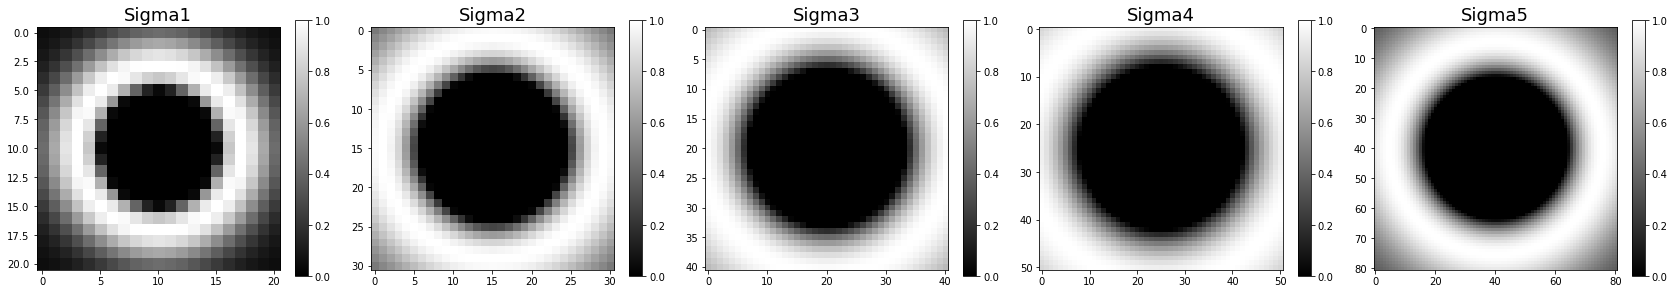

In [107]:
fig, ax = plt.subplots(1,5,figsize=(1 + 5*4.5,4))
display_axis_bw(ax[0],log_1,'Sigma1',normalized=True,fig=fig)
display_axis_bw(ax[1],log_2,'Sigma2',normalized=True,fig=fig)
display_axis_bw(ax[2],log_3,'Sigma3',normalized=True,fig=fig)
display_axis_bw(ax[3],log_4,'Sigma4',normalized=True,fig=fig)
display_axis_bw(ax[4],log_5,'Sigma5',normalized=True,fig=fig)
fig.tight_layout()
os.makedirs('Data/Solutions', exist_ok=True)
fig.savefig('Data/Solutions/question_2_7.pdf', format='pdf', bbox_inches='tight')

Convolve the image with the 5 filters. Note that we multiply the filters with -1 so that the maximum response is positive.

In [108]:
log_conv_1 = conv2D(img, -log_1)
log_conv_2 = conv2D(img, -log_2)
log_conv_3 = conv2D(img, -log_3)
log_conv_4 = conv2D(img, -log_4)
log_conv_5 = conv2D(img, -log_5)

#### **Answer 2.8**

In this sub-part, you will visualize the blob detection results. We also plot the colorbar with each image. You should use that to tune the values for `sigma`. 

Upload the saved image on Overleaf for Question 2.8.

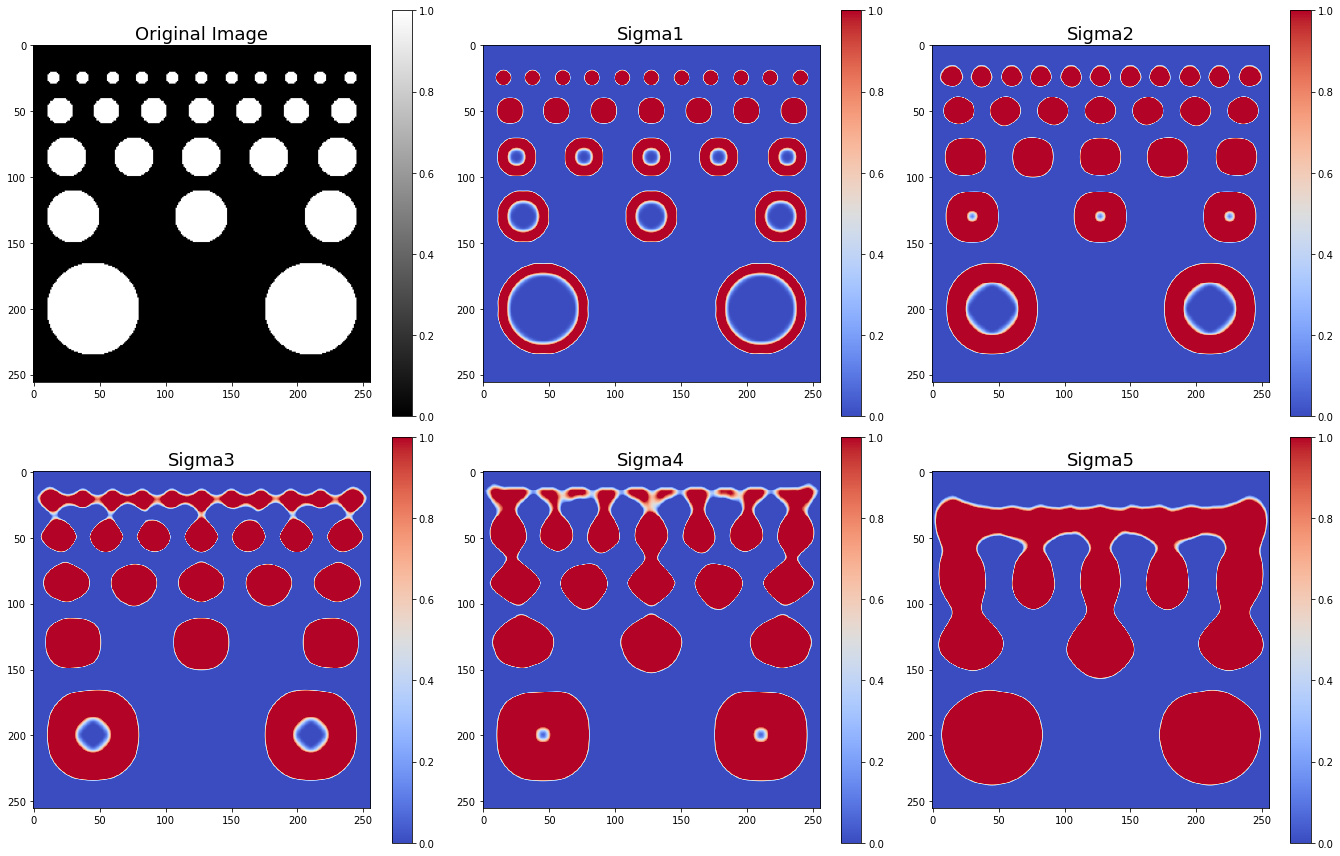

In [109]:
fig, ax = plt.subplots(2,3,figsize=(1 + 3*6,2*6))
display_axis_bw(ax[0,0],img,'Original Image',fig=fig)
display_axis_color(ax[0,1],log_conv_1,'Sigma1',fig=fig)
display_axis_color(ax[0,2],log_conv_2,'Sigma2',fig=fig)
display_axis_color(ax[1,0],log_conv_3,'Sigma3',fig=fig)
display_axis_color(ax[1,1],log_conv_4,'Sigma4',fig=fig)
display_axis_color(ax[1,2],log_conv_5,'Sigma5',fig=fig)
fig.tight_layout()
fig.savefig('Data/Solutions/question_2_8.pdf', format='pdf', bbox_inches='tight')

# Question 3

## Corner Detection

In this question, you will be implementing the Harris corner detector. Corners serve as useful features in images for a variety of reasons: they are salient, well localized, and invariant to a variety of transformations (illumination, rotation, and scale changes). The Harris corner detector also possesses some of these invariances (rotation and intensity shift) but is not invariant to image and intensity scaling. Nevertheless, the Harris corner detector is still a popular method for detecting corners in images.


A grayscale test image (normalized to be in [0, 1]) containing some squares and a warped checkerboard is constructed below.

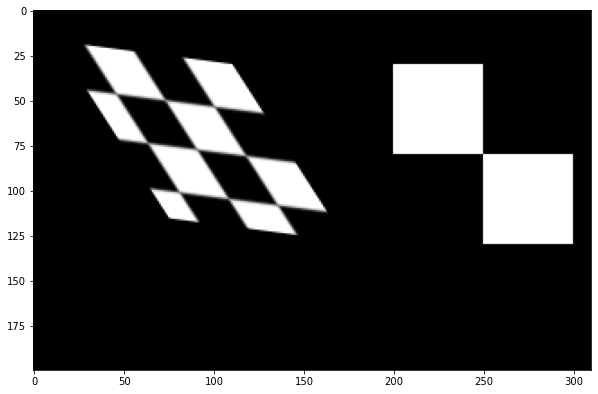

In [110]:
# Sheared checkerboard
tform = AffineTransform(scale=(1.3, 1.1), rotation=1, shear=0.7,
                        translation=(110, 30))
image = warp(data.checkerboard()[:90, :90], tform.inverse,
             output_shape=(200, 310))

# Two squares
image[30:80, 200:250] = 1
image[80:130, 250:300] = 1

display_gray(image)

### Computing Image Gradients

The first step in the Harris corner detector is to compute the image gradients. While there are a variety of different methods to compute gradients, you will use the Sobel filter, which is defined below for the x and y directions.

In [111]:
sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

After defining the Sobel filters, you need to apply them to obtain the gradients. Complete a function ```compute_image_gradient(image)``` that returns the horizontal (along the x direction) and vertical (along the y direction) image gradients using the provided Sobel filters. For this function (and all convolutions that follow), use the ```conv2D(image, kernel)``` function, which you should copy paste into the cell at the beginning of Question 2.

#### **Answer 3.1**

Copy paste your solution in the cell below on Overleaf for Question 3.1.

In [119]:
def compute_image_gradient(image: np.array):
    gradient_x = np.zeros_like(image, dtype=np.float32)
    gradient_x[:, :-2] += sobel_x[0, 0] * image[:, 2:]
    gradient_x[:, 1:-1] += sobel_x[0, 1] * image[:, 2:]
    gradient_x[:, 2:] += sobel_x[0, 2] * image[:, 2:]
    gradient_x[:, :-2] += sobel_x[2, 0] * image[:, :-2]
    gradient_x[:, 1:-1] += sobel_x[2, 1] * image[:, :-2]
    gradient_x[:, 2:] += sobel_x[2, 2] * image[:, :-2]
    gradient_x[:, 1:-1] += sobel_x[1, 0] * image[:, 2:]
    gradient_x[:, 1:-1] += sobel_x[1, 2] * image[:, :-2]

    gradient_y = np.zeros_like(image, dtype=np.float32)
    gradient_y[:-2, :] += sobel_y[0, 0] * image[2:, :]
    gradient_y[1:-1, :] += sobel_y[0, 1] * image[2:, :]
    gradient_y[2:, :] += sobel_y[0, 2] * image[2:, :]
    gradient_y[:-2, :] += sobel_y[2, 0] * image[:-2, :]
    gradient_y[1:-1, :] += sobel_y[2, 1] * image[:-2, :]
    gradient_y[2:, :] += sobel_y[2, 2] * image[:-2, :]
    gradient_y[1:-1, :] += sobel_y[1, 0] * image[2:, :]
    gradient_y[1:-1, :] += sobel_y[1, 2] * image[:-2, :]

    return gradient_x, gradient_y

Display the absolute gradient along the horizontal and vertical directions and their sum. You should observe that the gradient in the horizontal (x-direction) is unable to capture the horizontal edges while the gradient in the vertical (y-direction) is unable to capture the vertical edges. Both gradients capture the diagonal edges, but they may appear dimmer than the horizontal and vertical edges.

#### **Answer 3.2**

Execute the cell below and copy the saved image on Overleaf for Question 3.2.

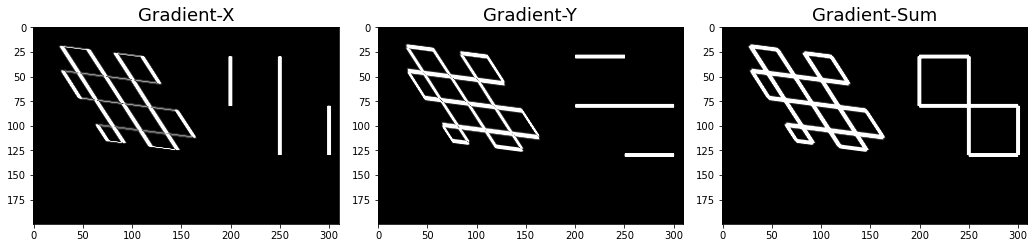

In [120]:
fig, ax = plt.subplots(1,3,figsize=(1 + 3*4.5,4))
img_gradient_x, img_gradient_y = compute_image_gradient(image)
display_axis(ax[0], np.abs(img_gradient_x), 'Gradient-X')
display_axis(ax[1], np.abs(img_gradient_y), 'Gradient-Y')
display_axis(ax[2], np.abs(img_gradient_x) + np.abs(img_gradient_y), 'Gradient-Sum')
fig.tight_layout()
os.makedirs('Data/Solutions', exist_ok=True)
fig.savefig('Data/Solutions/question_3_2.pdf', format='pdf', bbox_inches='tight')

### **Computing the Covariance Matrix**

After computing the gradients, the Harris corner detector then computes the covariance matrix of the gradients (see lecture 5 slide 26). Complete the function ```grad_covariance(image, size)``` that computes each pixel's covariance matrix using the ```size x size``` window centered at the pixel. This function should return three matrices $I_{xx}, I_{xy}, I_{yy}$ containing the top-left, diagonal, and bottom-right terms, respectively, of every pixel's covariance matrix. When computing the covariance, you do not need to subtract the means of the image gradients. The average filter is provided below as a useful function.

In [ ]:
# This is the standard box filter which computes the mean of all the pixels inside the filter.
def average_filter(size: int):
    assert size%2 == 1
    return 1.0 * np.ones((size,size))/(size**2)

#### **Answer 3.3**

Copy paste your solution in the cell below on Overleaf for Question 3.3.

In [122]:
def grad_covariance(image: np.array, size: int):
    I_x = convolve2d(image, sobel_x, mode='same', boundary='symm')
    I_y = convolve2d(image, sobel_y, mode='same', boundary='symm')

    I_xx = convolve2d(I_x * I_x, np.ones((size, size)), mode='same', boundary='symm')
    I_xy = convolve2d(I_x * I_y, np.ones((size, size)), mode='same', boundary='symm')
    I_yy = convolve2d(I_y * I_y, np.ones((size, size)), mode='same', boundary='symm')

    return I_xx, I_xy, I_yy

### **Harris Response Function**

Finally, the Harris corner detector uses the covariance matrix to compute a response function, which is then thresholded to obtain the locations of the corners. Complete the function ```harris_response(image, k, size)``` which computes the Harris response function (see lecture 5 slide 43, Harris & Stephens (1988)) for an image using a ```size x size``` window around every pixel. The parameter ```k``` corresponds to the parameter in the Harris response function.

#### **Answer 3.4**

Copy paste your solution in the cell below on Overleaf for Question 3.4.

In [133]:
def harris_response(image: np.array, k: float, size: int):
    dx = sobel_x
    dy = sobel_y
    
    Ix = convolve(image, dx)
    Iy = convolve(image, dy)
    Ixx = Ix**2
    Ixy = Ix*Iy
    Iyy = Iy**2
    
    kernel = np.ones((size, size))
    Sxx = convolve(Ixx, kernel)
    Sxy = convolve(Ixy, kernel)
    Syy = convolve(Iyy, kernel)
    
    det = (Sxx * Syy) - (Sxy**2)
    trace = Sxx + Syy
    response = det - k*(trace**2)
    
    return response

#### **Answer 3.5**

Execute the cell below and copy the saved image on Overleaf for Question 3.5. The cell below finds every pixel location where the Harris response function is above a certain threshold and then shows the locations of these pixels (the corner detections) in cyan.

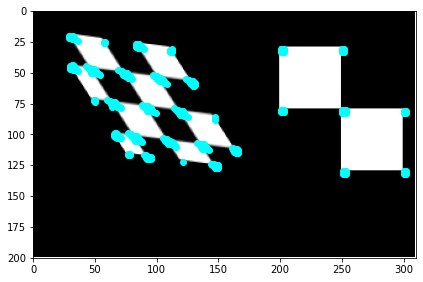

In [134]:
coords = np.argwhere(harris_response(image, 0.05, 3) > 0.02)
fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax.axis((0, 310, 200, 0))
fig.tight_layout()
plt.show()
fig.savefig('Data/Solutions/question_3_5.pdf', format='pdf', bbox_inches='tight')

### **Non-Maximum Suppression**

You should observe from the above image that all corners are detected. However, some corners are detected multiple times, which is due to simply thresholding the Harris response. To suppress multiple detections, you will implement, in steps, a function ```non_max_suppression(harris_response, distance, threshold)``` that applies non-maximum suppression to the Harris corner response and returns the remaining corner detections.

Non-maximum suppression works as follows: 
1. Threshold the Harris response map to obtain the pixel locations where the response is greater than a certain threshold. These pixel locations form our candidate corner detections.
2. Sort these detections based on maximum response value.
3. Go through the sorted detections in order and for each detection, remove other detections that are within a certain Euclidean distance from the current detection. This step suppresses detections that are not local maxima.

You will implement the three steps of non-maximum suppression in order. First, complete the function ```threshold_harris_response(harris_response, threshold)```, which returns the indices of the Harris response map corresponding to values that are greater than some threshold.

#### **Answer 3.6**

Copy paste your solution in the cell below on Overleaf for Question 3.6.

In [150]:
def threshold_harris_response(harris_response: np.array, threshold: float):
    threshold_image = np.zeros_like(harris_response)
    threshold_image[harris_response > threshold * harris_response.max()] = 1
    return threshold_image

Then, complete the function ```sort_detections(candidate_detections, harris_response)```, which returns the candidate detections sorted based on maximum Harris response value.

#### **Answer 3.7**

Copy paste your solution in the cell below on Overleaf for Question 3.7.


In [179]:
def sort_detections(candidate_detections: np.array, harris_response: np.array):    
    sorted_indices = np.argsort(harris_response.flatten())[::-1]
    sorted_detections = candidate_detections[sorted_indices]

    return sorted_detections

The final step is to go through the sorted detections and suppress detections that are not local maxima. Complete the function ```local_max(sorted_detections, distance)```, which goes through the sorted detections and returns only the detections that are local maxima (using local neighborhoods defined by a Euclidean distance threshold ```distance```).

A function that computes Euclidean distance between two points is provided below for convenience.

In [181]:
def l2_distance(p1: np.array, p2: np.array):
    return np.linalg.norm(p1 - p2, ord=2)

#### **Answer 3.8**

Copy paste your solution in the cell below on Overleaf for Question 3.8.


In [183]:
def local_max(sorted_detections: np.array, distance: float):
    valid_detections = []
    while sorted_detections:
        top = sorted_detections.pop(0)
        if not any(l2_distance(top, d) < distance for d in valid_detections):
            valid_detections.append(top)
    return np.asarray(valid_detections)

Now, combine the three previously implemented functions to complete the function ```non_max_suppression(harris_response, distance, threshold)```, which applies non-maximum suppression to the Harris corner response and returns the remaining corner detections as a NumPy array of (row, col) locations.

#### **Answer 3.9**

Copy paste your solution in the cell below on Overleaf for Question 3.9.

In [184]:
def non_max_suppression(harris_response: np.array, distance: float, threshold: float):
    candidate_detections = sort_detections(harris_response)
    maxima = local_max(candidate_detections, distance)
    maxima = threshold_harris_response_2d(maxima, threshold)
    return np.array([(x, y) for x, y, _ in maxima])

#### **Answer 3.10**

Execute the cell below and copy the saved image on Overleaf for Question 3.10. The cell below runs non-maximum suppression on the Harris response map and then shows the locations of the corner detections in cyan. Duplicate corner detections should now be removed.

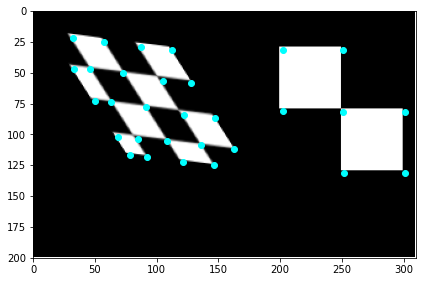

In [186]:
coords = non_max_suppression(harris_response(image, 0.05, 3), 10.0, 0.02)
fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
        linestyle='None', markersize=6)
ax.axis((0, 310, 200, 0))
fig.tight_layout()
plt.show()
fig.savefig('Data/Solutions/question_3_10.pdf', format='pdf', bbox_inches='tight')